<a id="title_ID"></a>
# Cutout of the TESS Full Frame Image Time Series using Python Requests

This notebook shows the user how to use the MAST programmatic interface to create a cutout of the small section of the TESS FFIs. For this example we will determine the RA and Dec for TOI 109.01, which is on TIC 29344935. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI time series, open the resulting target pixel files and plot the first image of each file with the WCS overlayed on the image.  

This tutorial shows the users how to do the following: use astroquery.catalogs to query the TIC, use the python requests module to query the available sectors, and python requests to obtain a ffi cutout with tesscut.


### Table of Contents 
  [Imports](#imports_ID) <br> 
  [Astroquery Search of the TIC](#catalog_ID) <br> 
  [Use Tesscut to get FFI Cutout](#tesscut_ID) <br>
  [Additional Resources](#resources_ID) <br> 
  [About this Notebook](#about_ID) 

## Import statements for this notebook.
<a id="imports_ID"></a>

In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline
#Next line puts your mast api token in a useful variable for later.
#See https://auth.mast.stsci.edu/info
masttoken=%env MAST_API_TOKEN

## Get RA and Dec of your target using Astroquery Catalogs
<a id="catalog_ID"></a>
Here we use the astroquery.mast Catalogs query_criteria function to request the RA and Dec of for the object with TIC ID = 29344935. We collect the RA and Declination and store them in their own variables.  For good measure, we print out some of the resulting values from the catalog search in a table.  
<p>
Note, that the catalog name is "Tic". This specific capitalization is required for this to work.

In [2]:
ticid=25155310
rad_search=1/60 #radius in degrees
catalogData=Catalogs.query_criteria(catalog="Tic",ID=str(ticid))
#catalogData = Catalogs.query_object(starName, radius=rad_search, catalog="TIC")
Ra=catalogData[0]['ra']
Dec=catalogData[0]['dec']
catalogData[0]['ID','Jmag','ra','dec','objType']

ID,Jmag,ra,dec,objType
str8,float64,float64,float64,str4
25155310,9.962,63.37389,-69.226789,STAR


## Use sector query to determine which TESS sectors have FFI data
<a id="catalog_ID"></a>
Using the tess sector information service, we make a request to determine which sectors/cameras/CCDs contain data for this target. Remember that there is a set of FFIs for each Sector and those are broken up into 4 cameras which each have 4 CCDs.  We will do this with a radius=0 cone search to find only those FFI sets that contain the star of interest. You can make the query using a larger radius, which may matter if the star is near the edge of one of the CCDs.
<p>
Note, the request is returned in a json format. The 'results' key contains an array of dictionaries with the information we are looking for.  

In [3]:
myparams={"ra":Ra, "dec":Dec, "radius":"0m"}
url="https://mastdev.stsci.edu/tesscut/api/v0.1/sector"

requestData=requests.get(url=url,params=myparams)
print(requestData.headers.get('content-type'))

application/json; charset=UTF-8


In [4]:
sectors=requestData.json()['results']
sectors

[{'sectorName': 'tess-s0001-4-1', 'sector': '0001', 'camera': '4', 'ccd': '1'},
 {'sectorName': 'tess-s0002-4-2', 'sector': '0002', 'camera': '4', 'ccd': '2'}]

Each element of the array shows one set of sector, camer and CCD that has data for the requested region of sky. 

<a id="tesscut_id"></a>
## Request a 10 x 10 pixel timeseries of FFI cutouts around specified RA and Dec.
This delivers a zipped file containing a cutout for each set of FFIs as listed above. It is also possible to request only one sector using the "sector" parameter.

In [73]:
myparams={"ra":Ra, "dec":Dec, "x":21, "y":11, 
           "units":"px","sector":"All"}
header={'Authorization': "token "+masttoken}

url="https://mastdev.stsci.edu/tesscut/api/v0.1/astrocut"

r=requests.get(url=url,params=myparams,headers=header)
#Check the content type.
print(r)
print(r.headers.get('content-type'))

<Response [200]>
application/zip


In [74]:
open('astrocut.zip', 'wb').write(r.content)

4264224

### Open the zip file so we can see what is in the header of the two files.
We use python's zipfile to unzip the file, but this could also be done using unzip from the command line.  

In [75]:
zipRef=zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0001-4-1_63.37389_-69.226789_11x21_astrocut.fits', 'tess-s0002-4-2_63.37389_-69.226789_11x21_astrocut.fits']


### Inspect the contents of both files.
Use the fits.info function to see the contents of the file. Notice that it has three extensions just like a target pixel file. Most of the interesting information is in the PIXELS extension.

In [84]:
file1=cutoutnames[0]
file2=cutoutnames[1]
fits.setval(file1, 'TDIM4', value='(11,21)', ext=1)
fits.setval(file1,'TDIM5', value='(11,21)', ext=1)
fits.info(file1)

Filename: tess-s0001-4-1_63.37389_-69.226789_11x21_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1282R x 12C   [D, E, J, 231J, 231E, 231E, 231E, 231E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (21, 11)   float64   


In [77]:
fits.info(file1)

Filename: tess-s0001-4-1_63.37389_-69.226789_11x21_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1282R x 12C   [D, E, J, 231J, 231E, 231E, 231E, 231E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (21, 11)   float64   


In [85]:
hdu1=fits.open(file1)
hdu1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4686 / length of dimension 1                          
NAXIS2  =                 1282 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'TIME    '           / column name                                    
TFORM1  = 'D       '           / column format                                  
TUNIT1  = 'BJD - 2457000, days' / unit                                          
TDISP1  = 'D14.7   '           / display format                                 
TTYPE2  = 'TIMECORR'        

### Compare the time for the start of observation for both files.
Since one is from Sector 1 and the other is from Sector 2, these are approximately a month a part. 

In [86]:
hdu2=fits.open(file2)
print("File 1 Start Time: " + hdu1[0].header['DATE-OBS'])
print("File 2 Start Time: " + hdu2[0].header['DATE-OBS'])
print(np.shape(hdu1[1].data[0]['FLUX']))
print(np.shape(hdu1[2].data))

File 1 Start Time: 2018-07-25T19:29:42.708Z
File 2 Start Time: 2018-08-23T14:29:41.724Z
(21, 11)
(11, 21)


<a id="plot_image"></a>
## Plot the First Image of the First Sector of Data

We use the WCS in the header to place a red dot on the image for the catalog position of the star on the figure as a demonstration of the WCS. Remember that the WCS is based on the WCS stored in the FFI file for the central part of the time series and there can be some motion during a sector of observation. 

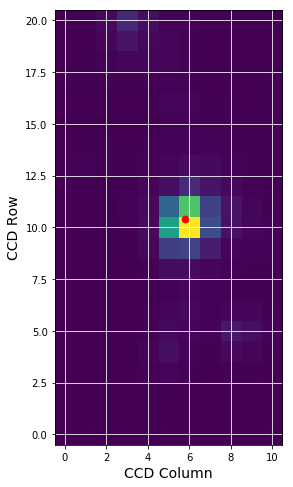

In [91]:
first_image=hdu1[1].data['FLUX'][0]
wcs=WCS(hdu1[2].header)

fig = plt.figure(figsize=(8,8))
fig.clf()
#fig.add_subplot(111, projection=wcs)
plt.imshow(first_image, origin='lower', cmap=plt.cm.viridis)
#plt.imshow(first_image.reshape(np.shape(first_image)[::-1]), origin='lower', cmap=plt.cm.viridis)
plt.xlabel('CCD Column',fontsize=14)
plt.ylabel('CCD Row',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

starloc=wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starloc[0,0],starloc[0,1],s=45,color='red')

21
11


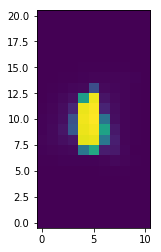

In [81]:
tpfile="https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_tp.fits"
tpfile="https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00092352620-s01_tess_v1_tp.fits"
tpfile="https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_tp.fits"
tphdu=fits.open(tpfile)

tpimage=tphdu[1].data['FLUX'][10]


plt.figure()
plt.imshow(tpimage,origin='lower')
print(tphdu[2].header['NAXIS2'])
print(hdu1[2].header['NAXIS2'])

<a id="resources_ID"></a>
## Additional Resources
[TESScut API Documentation](https://mast.stsci.edu/tesscut/)<br>
[Astrocut Documentation](https://astrocut.readthedocs.io/en/latest/)<br>
[TESS Homepage](https://archive.stsci.edu/tess)


<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-11-13

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 